In [1]:
top_path = '/scratch/user/zshuying/ppi_mutation/scripts'
clinvar_path='/scratch/user/zshuying/ppi_mutation/data/clinvar/'
process_path='/scratch/user/zshuying/ppi_mutation/data/baseline1/processed/'
import torch
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
global top_path  # the path of the top_level directory
global script_path, data_path, logging_path
import os, sys
sys.path.append(top_path)
from torch.utils.data import DataLoader
import esm
from baseline0.datasets import *
import numpy as np
from argparse import ArgumentParser
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from baseline0.model import *
import pandas as pd
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

pj=os.path.join




In [ ]:
mark the prediction on the figure

## Visualizations of Embeddings from esm2_t6_8M_UR50D()


In [2]:
# Read_data_function()
def read_data(train_list_name,val_list_name,test_list_name,train_val_path=pj(clinvar_path,'mutant_seq_2019_1_no_error.csv'),test_path=pj(clinvar_path,'mutant_seq_2019_test_no_error.csv'),ppi_path=pj(top_path,'ppi_seq_huri_humap.csv')):
    train_val_df,test_df=pd.read_csv(train_val_path),pd.read_csv(test_path)
    with open(pj(process_path,train_list_name),'r') as f:
        train_list=eval(f.readline())
    with open(pj(process_path,val_list_name),'r') as f:
        val_list=eval(f.readline())
    with open(pj(process_path,test_list_name),'r') as f:
        test_list=eval(f.readline())
    ppi_uniprot=set(pd.read_csv(ppi_path)['UniProt'].tolist())
    train_actual_df,val_actual_df,test_actual_df=train_val_df[train_val_df['Name'].apply(lambda x:x in train_list)],\
        train_val_df[train_val_df['Name'].apply(lambda x:x in val_list)],test_df[test_df['Name'].apply(lambda x:x in test_list)]
    train_actual_uniprot,val_actual_uniprot,test_actual_uniprot=set(train_actual_df.UniProt.unique().tolist()),\
        set(val_actual_df.UniProt.unique().tolist()),set(test_actual_df.UniProt.unique().tolist())
    return train_actual_uniprot,val_actual_uniprot,test_actual_uniprot,ppi_uniprot



#read embeddings

def load_embedding(train_uniprot,val_uniprot,test_uniprot,ppi_uniprot,pth_path=pj(data_path,'baseline1/all_wild_esm_embds.pt')):
    pth=torch.load(pth_path)
    seqs=[]
    y=[]
    uniprots=pd.read_csv(pj(top_path,'ppi_seq_huri_humap.csv'))['UniProt'].unique().tolist()
    for uniprot in uniprots:
        seqs.append(pth[uniprot]['embs'])
        if uniprot in train_uniprot:
            y.append(0)
        elif uniprot in val_uniprot:
            y.append(1)
        elif uniprot in test_uniprot:
            y.append(2)
        else:
            y.append(3)
    return seqs,y
    # seqs: 11186 * 320



# UMAP
def compute_umap(n_neighbors,seqs):
    umap_reducer=umap.UMAP(n_neighbors=n_neighbors)
    embedding_reduced = umap_reducer.fit_transform(seqs)
    return embedding_reduced

def compute_pca(n_components,seqs):
    pca = PCA(n_components)
    X= pca.fit_transform(seqs)
    print('explained variance ratio = %s'%pca.explained_variance_ratio_)
    return X

def plot_one_figure(x, y, ax, cdict, marker_size_dict, title):
    """
    Plots a scatter plot with customized colors and markers.
    :param x: X data (2D array for x and y coordinates).
    :param y: Y data (labels for coloring and marker size).
    :param cdict: Dictionary mapping y values to colors.
    :param marker_size_dict: Dictionary mapping y values to marker sizes.
    :param title: Title of the plot.
    :param fig_dims: Dimensions of the figure.
    """
    colored_y = [cdict[val] for val in y]
    marker_y = [marker_size_dict[val] for val in y]
    ax.scatter(x[:, 0], x[:, 1], s=marker_y, c=colored_y)
    ax.set_title(title)
    markers = [plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in cdict.values()]
    ax.legend(markers, ['train_wild', 'val_wild', 'test_wild', 'ppi_wild not variant'], numpoints=1, fontsize=16)

def plot_figures(nrows, ncols, x_pca,x_umap,y):
    """
    Creates multiple figures, each with its own scatter plot.
    :param nrows: Number of rows in the figure layout.
    :param ncols: Number of columns in the figure layout.
    :param cdict: Dictionary mapping y values to colors for scatter plot.
    :param marker_size_dict: Dictionary mapping y values to marker sizes for scatter plot.
    :param fig_dims: Dimensions of each figure.
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    if nrows == 1 and ncols == 1:
        axes = [axes]
    elif nrows == 1 or ncols == 1:
        axes = axes.flatten()
    else:
        axes = axes.ravel()
    marker_size_dict=[3,8,3,3]
    # train+val+test vs ppi(outside of trainvaltest)
    cdict = {0: ('green',0.5),1: ('orange',0.5), 2: ('green',0), 3: ('orange',0)}
    plot_one_figure(x_pca, y, axes[0], cdict, marker_size_dict, title='PCA: train vs val')
    plot_one_figure(x_umap, y, axes[1], cdict, marker_size_dict, title='UMAP: train vs val')

    cdict = {0: ('green',0.5),1: ('orange',0), 2: ('orange',0.5), 3: ('orange',0)}
    plot_one_figure(x_pca, y, axes[2], cdict, marker_size_dict, title='PCA: train vs test')
    plot_one_figure(x_umap, y, axes[3], cdict, marker_size_dict, title='UMAP: train vs test')

    cdict = {0: ('green',0),1: ('orange',0.5), 2: ('green',0.5), 3: ('orange',0)}
    plot_one_figure(x_pca, y, axes[4], cdict, marker_size_dict, title='PCA: val vs test')
    plot_one_figure(x_umap, y, axes[5], cdict, marker_size_dict, title='UMAP: val vs test')


    cdict = {0: ('green',0),1: ('green',0), 2: ('green',0.5), 3: ('orange',0.5)}
    plot_one_figure(x_pca, y, axes[6], cdict, marker_size_dict, title='PCA: test vs ppi(outside of trainvaltest)')
    plot_one_figure(x_umap, y, axes[7], cdict, marker_size_dict, title='UMAP: test vs ppi(outside of trainvaltest)')


    plt.tight_layout()
    plt.show()


# Example usage with sample color and marker size dictionaries
# cdict = {0: 'blue', 1: 'green', 2: 'red', 3: 'purple'}
# marker_size_dict = {0: 50, 1: 100, 2: 150, 3: 200}
# plot_figures(2, 2, cdict, marker_size_dict)  # Create 4 separate plots in a 2x2 layout#split 0:
#train_list_name,val_list_name,test_list_name='2019_train_name_list_1050.txt','2019_val_name_list_1050.txt','2019_test_name_list_1050.txt'

#### Visualization for split 1050

In [34]:
train_actual_uniprot,val_actual_uniprot,test_actual_uniprot,ppi_uniprot=read_data('2019_train_name_list_1050.txt','2019_val_name_list_1050.txt','2019_test_name_list_1050.txt')
X,y=load_embedding(train_uniprot=train_actual_uniprot,val_uniprot=val_actual_uniprot,test_uniprot=test_actual_uniprot,ppi_uniprot=ppi_uniprot)
X_umap_0=compute_umap(15,X)
X_pca_0=compute_pca(2,X)

explained variance ratio = [0.1853954  0.10450519]


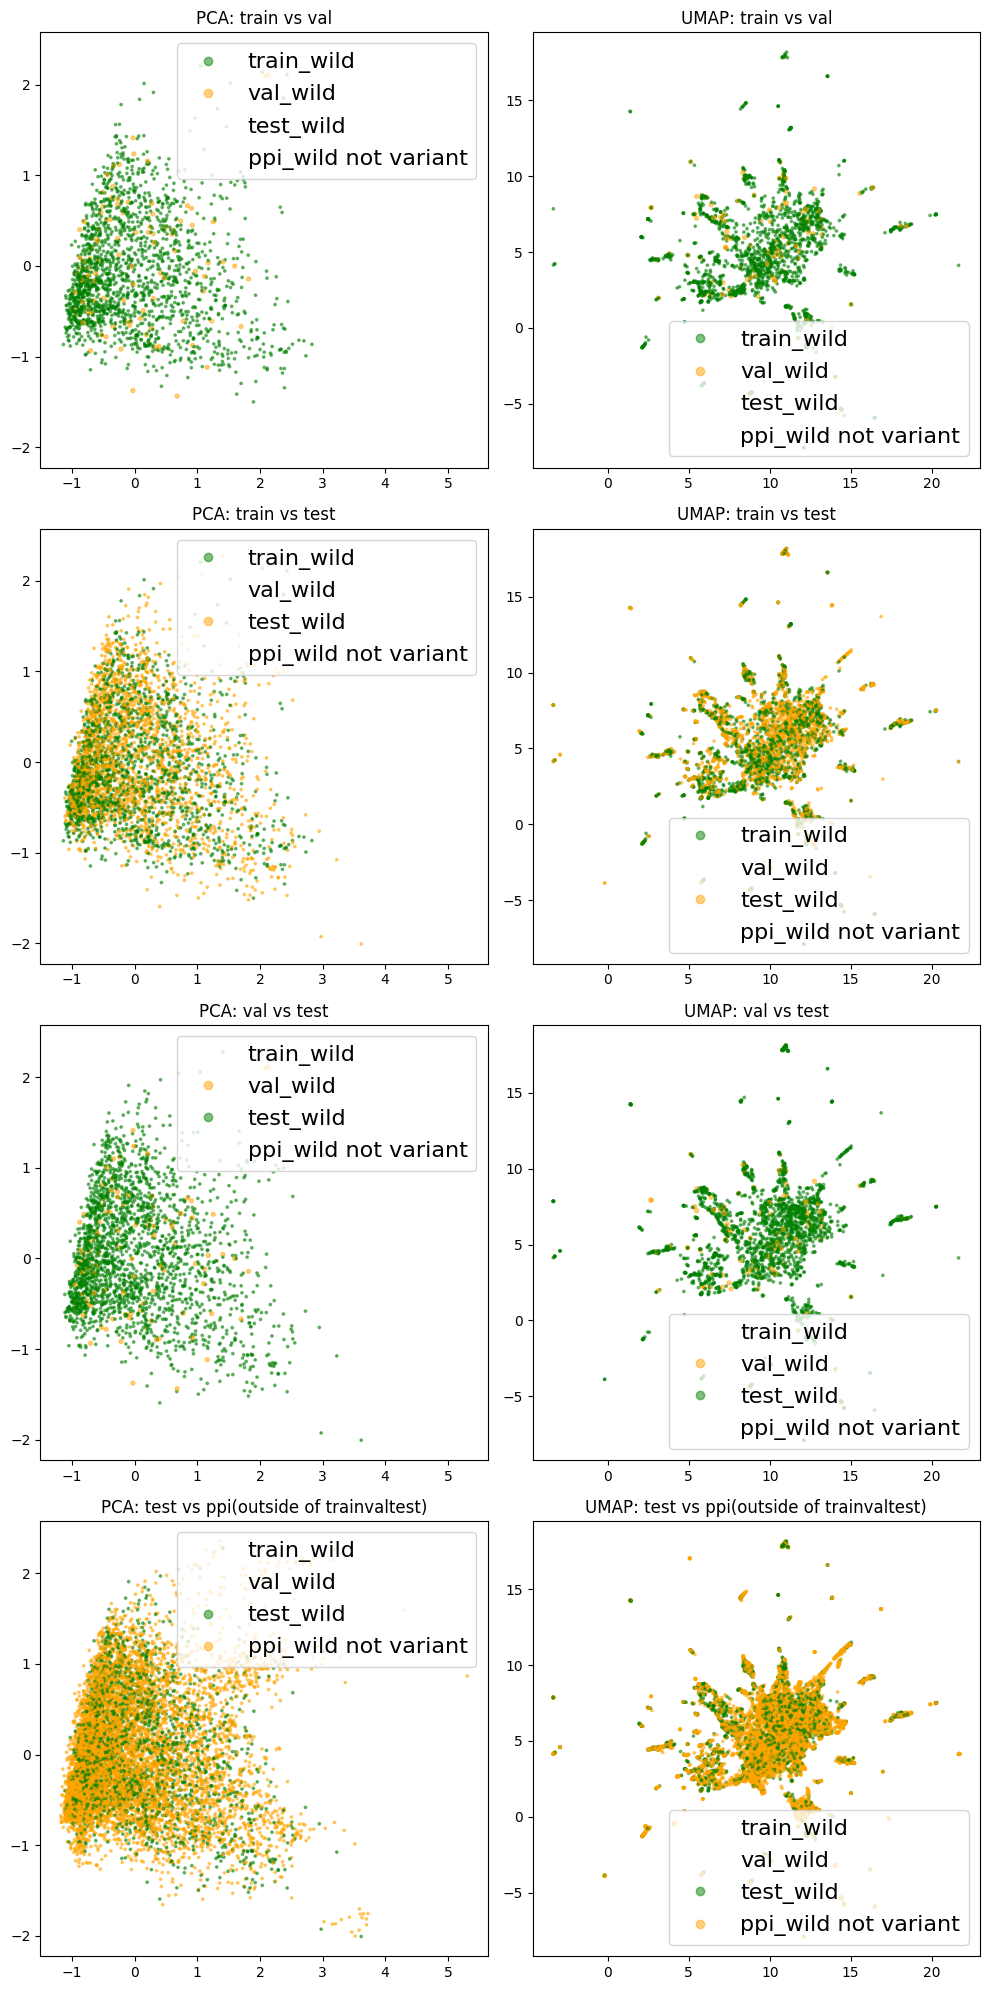

In [35]:
plot_figures(4,2,X_pca_0,X_umap_0,y)

#### Visualization for manual split 1

In [32]:
train_actual_uniprot,val_actual_uniprot,test_actual_uniprot,ppi_uniprot=read_data('2019_train_name_list_manual1.txt','2019_val_name_list_manual1.txt','2019_test_name_list_1050.txt')
X,y=load_embedding(train_uniprot=train_actual_uniprot,val_uniprot=val_actual_uniprot,test_uniprot=test_actual_uniprot,ppi_uniprot=ppi_uniprot)
X_umap_1=compute_umap(30,X)
X_pca_1=compute_pca(2,X)

explained variance ratio = [0.1853954  0.10450519]


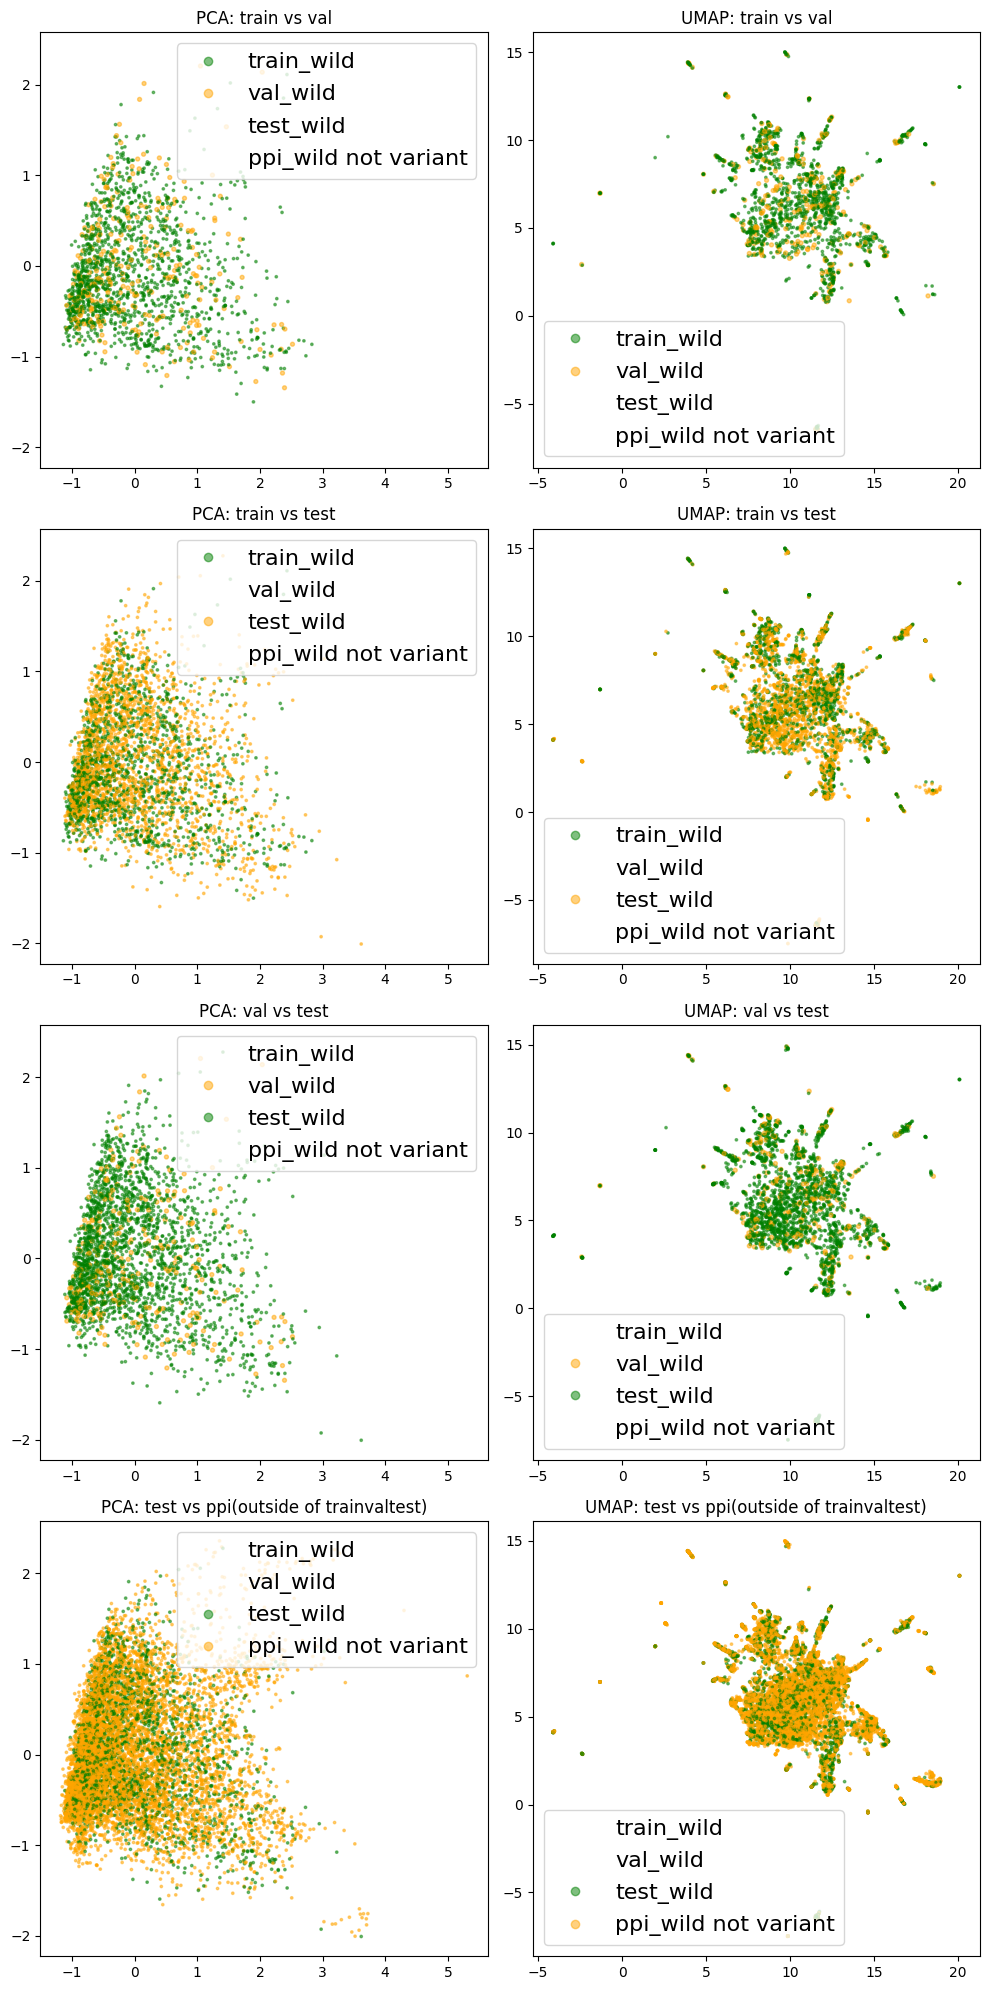

In [33]:
plot_figures(4,2,X_pca_1,X_umap_1,y)

## Investigate Degree of separation between sets in the PPI graph

In [3]:
# construct PPI graph
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
G=nx.Graph(name='Protein Interaction Graph')
with open('/scratch/user/zshuying/ppi_mutation/ppi_huri_humap.txt','r') as f:
    interactions=list(eval(f.readline()))
uniprots=pd.read_csv('/scratch/user/zshuying/ppi_mutation/ppi_seq_huri_humap.csv')['UniProt'].tolist()
# useful_interactions=[item.split('-') for item in interactions if (item.split('-')[0] in uniprots and item.split('-')[1] in uniprots)]
useful_interactions=[item.split('-') for item in interactions]
G.add_edges_from(useful_interactions)

In [4]:
def calculate_set_operations(train_actual_uniprot, val_actual_uniprot, test_actual_uniprot, ppi_uniprot):
    # Calculating differences
    results = {
        "Difference train - val": train_actual_uniprot - val_actual_uniprot,
        "Difference train - test": train_actual_uniprot - test_actual_uniprot,
        "Difference train - ppi": train_actual_uniprot - ppi_uniprot,
        "Difference val - train": val_actual_uniprot - train_actual_uniprot,
        "Difference val - test": val_actual_uniprot - test_actual_uniprot,
        "Difference val - ppi": val_actual_uniprot - ppi_uniprot,
        "Difference test - train": test_actual_uniprot - train_actual_uniprot,
        "Difference test - val": test_actual_uniprot - val_actual_uniprot,
        "Difference test - ppi": test_actual_uniprot - ppi_uniprot,
        "Difference ppi - train": ppi_uniprot - train_actual_uniprot,
        "Difference ppi - val": ppi_uniprot - val_actual_uniprot,
        "Difference ppi - test": ppi_uniprot - test_actual_uniprot
    }

    # Calculating intersections
    results.update({
        "Intersection train & val": train_actual_uniprot & val_actual_uniprot,
        "Intersection train & test": train_actual_uniprot & test_actual_uniprot,
        "Intersection train & ppi": train_actual_uniprot & ppi_uniprot,
        "Intersection val & train": val_actual_uniprot & train_actual_uniprot,
        "Intersection val & test": val_actual_uniprot & test_actual_uniprot,
        "Intersection val & ppi": val_actual_uniprot & ppi_uniprot,
        "Intersection test & train": test_actual_uniprot & train_actual_uniprot,
        "Intersection test & val": test_actual_uniprot & val_actual_uniprot,
        "Intersection test & ppi": test_actual_uniprot & ppi_uniprot,
        "Intersection ppi & train": ppi_uniprot & train_actual_uniprot,
        "Intersection ppi & val": ppi_uniprot & val_actual_uniprot,
        "Intersection ppi & test": ppi_uniprot & test_actual_uniprot
    })

    return results

In [5]:
def f(sets_dict, graph):
    degrees_of_separation = {}

    # List of keys (set names) from the dictionary
    set_names = list(sets_dict.keys())

    # Iterate over each unique pair of sets
    for i in range(len(set_names)):
        for j in range(i + 1, len(set_names)):
            set1_name, set2_name = set_names[i], set_names[j]
            set1, set2 = sets_dict[set1_name], sets_dict[set2_name]
            key = f'{set1_name} and {set2_name}'  # Key for the dictionary

            degrees_of_separation[key] = []  # Initialize list for this pair

            # Calculate degree of separation for every pair of nodes from set1 and set2
            degrees_of_separation[key] = [nx.shortest_path_length(graph, source=node1, target=node2)
                                          if nx.has_path(graph, node1, node2) else None
                                          for node1 in set1 for node2 in set2]

    return degrees_of_separation

In [1]:
train_actual_uniprot,val_actual_uniprot,test_actual_uniprot,ppi_uniprot=read_data('2019_train_name_list_manual1.txt','2019_val_name_list_manual1.txt','2019_test_name_list_1050.txt')
set_dict=calculate_set_operations(train_actual_uniprot&ppi_uniprot,val_actual_uniprot,test_actual_uniprot,ppi_uniprot)
degrees_of_separations=f(set_dict,G)

NameError: name 'read_data' is not defined

In [16]:
G.nodes

NodeView(('Q14973', 'Q53HI1', 'Q9NWZ8', 'Q8WXD5', 'P35680', 'Q6NVU6', 'Q9BUL8', 'Q9Y6E0', 'P10606', 'Q9NQX0', 'O60826', 'Q86VX2', 'Q9BYD6', 'Q13084', 'Q01432', 'Q9NZI2', 'P16083', 'A0A075B6E9', 'P41227', 'Q96D03', 'O95363', 'P07951', 'Q96PS8', 'Q8WWF3', 'Q5T753', 'Q9BYR9', 'Q9BTE1', 'P63167', 'Q86VP1', 'Q96CS7', 'Q9HD20', 'Q5SR56', 'Q9NP66', 'P37235', 'O75603', 'O75031', 'Q16718', 'Q9H8W4', 'P50222', 'P29803', 'P32969', 'Q96MF2', 'P02100', 'P02008', 'Q8IYD9', 'P43364', 'Q8N6L0', 'Q96D05', 'P24941', 'P20248', 'Q8TBB1', 'Q9BPW4', 'P01350', 'Q96BA8', 'P05198', 'Q08AM6', 'Q99801', 'Q8TAU3', 'Q71RG4', 'Q4KMG9', 'Q99750', 'Q9BT49', 'Q8ND83', 'Q9NR12', 'Q7Z3S9', 'Q8NDP4', 'Q99523', 'O95183', 'Q9Y5U4', 'Q9UI30', 'O43709', 'Q13541', 'P25791', 'O75558', 'Q9NS73', 'Q15323', 'Q9HBH7', 'Q13137', 'Q6PF15', 'O14964', 'Q13503', 'Q13077', 'Q9HAK2', 'Q7Z6J0', 'P14598', 'P52306', 'Q5JST6', 'Q15735', 'Q9BY50', 'P09601', 'P86479', 'Q8IUQ4', 'Q6P1L6', 'Q9Y2K6', 'Q8WXA3', 'Q96T51', 'Q86T90', 'Q9NWQ4', 'Q96BR

In [16]:
'P42356' in G, 'P42356' in train_actual_uniprot, 'P42356' in uniprots, 'P42356' in uniprots_useful_interactions


(False, True, True, False)

In [12]:
uniprots_useful_interactions={name for pair in useful_interactions for name in pair}

In [17]:
len(uniprots_useful_interactions),len(uniprots)

(11154, 11186)

In [18]:
from baseline1.datasets_baseline1 import *

Global seed set to 1050


In [19]:
ppi=VariantPPI(root='/scratch/user/zshuying/ppi_mutation/data/baseline1',variant_embedding_path='/scratch/user/zshuying/ppi_mutation/data/baseline0/2019_variant_embds.pt', wild_embedding_path='/scratch/user/zshuying/ppi_mutation/data/baseline1/all_wild_esm_embds.pt', variant_list_name='2019_train_name_list_manual1')